In [1]:
import matplotlib.pyplot as plt

# 支持多行输出
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

# 中文的正常显示
plt.rcParams['font.sans-serif']=['SimHei'] 

#用来正常坐标轴的数字的负号
plt.rcParams['axes.unicode_minus']=False

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 读取数据

In [2]:
!tree data/cats_and_dogs_small

卷 大数据与人工智能 的文件夹 PATH 列表
卷序列号为 0000007D 0C3E:0BA7
E:\DEEPLEARNING\DATA\CATS_AND_DOGS_SMALL
├─test
│  ├─cats
│  └─dogs
├─train
│  ├─cats
│  └─dogs
└─validation
    ├─cats
    └─dogs


In [3]:
import os

base_dir = 'data/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


# 数据增强

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# 数据增强
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 调用预训练卷积层

In [5]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# 使用预训练的卷积层搭建神经网络

In [6]:
import tensorflow.keras as keras
model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## 冻结卷积基

In [7]:
# 将卷积基冻结
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


# 训练模型

In [9]:
# 模型编译
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

In [10]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Epoch 1/30


C:\Users\HP\AppData\Local\Temp\ipykernel_9020\2776787710.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


100/100 [==============================] - 20s 160ms/step - loss: 0.6129 - accuracy: 0.6645 - val_loss: 0.4710 - val_accuracy: 0.8160
Epoch 2/30
100/100 [==============================] - 16s 160ms/step - loss: 0.4933 - accuracy: 0.7900 - val_loss: 0.3826 - val_accuracy: 0.8470
Epoch 3/30
100/100 [==============================] - 16s 161ms/step - loss: 0.4402 - accuracy: 0.8125 - val_loss: 0.3338 - val_accuracy: 0.8750
Epoch 4/30
100/100 [==============================] - 16s 162ms/step - loss: 0.4070 - accuracy: 0.8265 - val_loss: 0.3193 - val_accuracy: 0.8740
Epoch 5/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3971 - accuracy: 0.8285 - val_loss: 0.2965 - val_accuracy: 0.8840
Epoch 6/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3715 - accuracy: 0.8265 - val_loss: 0.2893 - val_accuracy: 0.8900
Epoch 7/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3728 - accuracy: 0.8380 - val_loss: 0.2870 - val_accuracy: 0.8

# 可视化训练过程

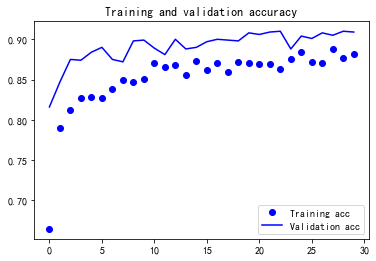

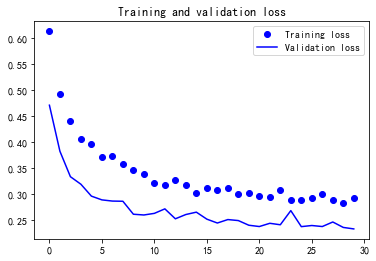

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

# 保存模型到本地

In [12]:
model.save('CatsAndDogsVGG16.h5')

# 模型微调

In [13]:
# 卷积基仍处于冻结状态
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
# 打印VGG各层的名字
for layer in conv_base.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [15]:
# 将block5层全部解冻
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
# 观察参数中有多少是可以训练的、多少被冻结的
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [17]:
# 特别注意，此处的代码中没有再重新定义模型，使用的还是以前训练的模型
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Epoch 1/100


E:\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


100/100 [==============================] - 20s 184ms/step - loss: 0.2914 - accuracy: 0.8740 - val_loss: 0.2201 - val_accuracy: 0.9040
Epoch 2/100
100/100 [==============================] - 18s 184ms/step - loss: 0.2655 - accuracy: 0.8880 - val_loss: 0.2359 - val_accuracy: 0.9040
Epoch 3/100
100/100 [==============================] - 19s 185ms/step - loss: 0.2587 - accuracy: 0.8880 - val_loss: 0.2011 - val_accuracy: 0.9200
Epoch 4/100
100/100 [==============================] - 19s 186ms/step - loss: 0.2276 - accuracy: 0.9030 - val_loss: 0.2309 - val_accuracy: 0.9100
Epoch 5/100
100/100 [==============================] - 19s 187ms/step - loss: 0.2233 - accuracy: 0.9065 - val_loss: 0.1802 - val_accuracy: 0.9260
Epoch 6/100
100/100 [==============================] - 19s 187ms/step - loss: 0.1813 - accuracy: 0.9255 - val_loss: 0.2064 - val_accuracy: 0.9230
Epoch 7/100
100/100 [==============================] - 19s 188ms/step - loss: 0.1914 - accuracy: 0.9155 - val_loss: 0.1700 - val_accurac

Epoch 57/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0352 - accuracy: 0.9900 - val_loss: 0.3247 - val_accuracy: 0.9230
Epoch 58/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0376 - accuracy: 0.9825 - val_loss: 0.1989 - val_accuracy: 0.9330
Epoch 59/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0393 - accuracy: 0.9845 - val_loss: 0.2197 - val_accuracy: 0.9390
Epoch 60/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0325 - accuracy: 0.9905 - val_loss: 0.2217 - val_accuracy: 0.9400
Epoch 61/100
100/100 [==============================] - 19s 189ms/step - loss: 0.0315 - accuracy: 0.9890 - val_loss: 0.2287 - val_accuracy: 0.9410
Epoch 62/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0312 - accuracy: 0.9915 - val_loss: 0.2097 - val_accuracy: 0.9390
Epoch 63/100
100/100 [==============================] - 19s 189ms/step - loss: 0.0360 - accuracy: 0.9870 - val_loss: 0

## 可视化训练过程

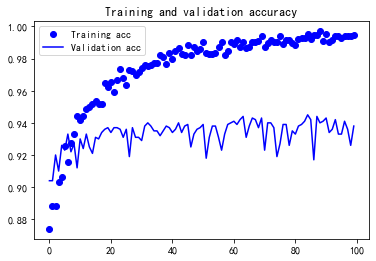

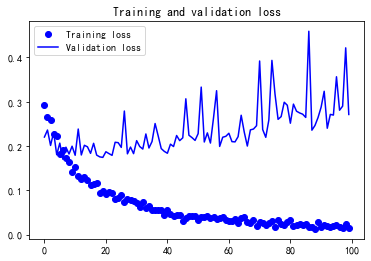

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

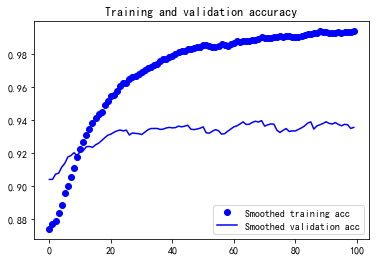

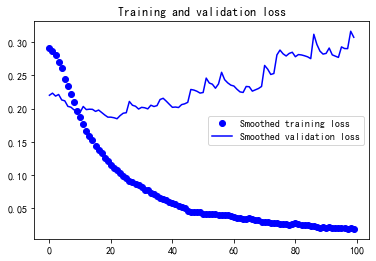

In [19]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

## 保存模型

In [20]:
model.save('CatsAndDogsVGG16_fine-tuning.h5')

## 模型评估 

In [22]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('测试集准确率：', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 97ms/step - loss: 0.3402 - accuracy: 0.9380
测试集准确率： 0.9380000233650208
